# *MillGuard* — Predictive maintenance for milling equipment  

### Import Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Get Dataset

Dataset Overview

This synthetic dataset simulates the operational behavior of a milling machine. It contains 10,000 observations (rows), each representing a single production instance with 14 features (columns). The data is designed to model realistic process conditions and failure mechanisms.

| Feature                     | Description                                                                                                                                                                                               |
| --------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **UID**                     | Unique identifier ranging from 1 to 10,000.                                                                                                                                                               |
| **Product ID**              | A composite identifier consisting of a quality code (`L`, `M`, or `H`) — representing low (50% of samples), medium (30%), and high (20%) quality variants — followed by a variant-specific serial number. |
| **Type**                    | The product quality type extracted from the Product ID (`L`, `M`, or `H`).                                                                                                                                |
| **Air Temperature [K]**     | Simulated using a random walk process, normalized to a standard deviation of 2 K around a mean of 300 K.                                                                                                  |
| **Process Temperature [K]** | Generated from a random walk process normalized to 1 K standard deviation, added to the air temperature plus 10 K.                                                                                        |
| **Rotational Speed [rpm]**  | Calculated based on a power of 2860 W with additional Gaussian noise.                                                                                                                                     |
| **Torque [Nm]**             | Normally distributed around 40 Nm with a standard deviation of 10 Nm, ensuring no negative values.                                                                                                        |
| **Tool Wear [min]**         | Tool wear increases based on product quality: +2 min for L, +3 min for M, and +5 min for H variants.                                                                                                      |
| **Machine Failure**         | Binary label indicating whether the machine failed during this process (1 = failure, 0 = no failure). Failures arise from one or more of the independent failure modes below.                             |


In [4]:
mill_df = pd.read_csv('../dataset/ai4i2020.csv')

In [6]:
mill_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [7]:
mill_df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [8]:
mill_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [12]:
mill_df.isnull().sum() # Check for missing values

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [10]:
mill_df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Machine failure                2
TWF                            2
HDF                            2
PWF                            2
OSF                            2
RNF                            2
dtype: int64

### Data Distribution

#### Machine Failure

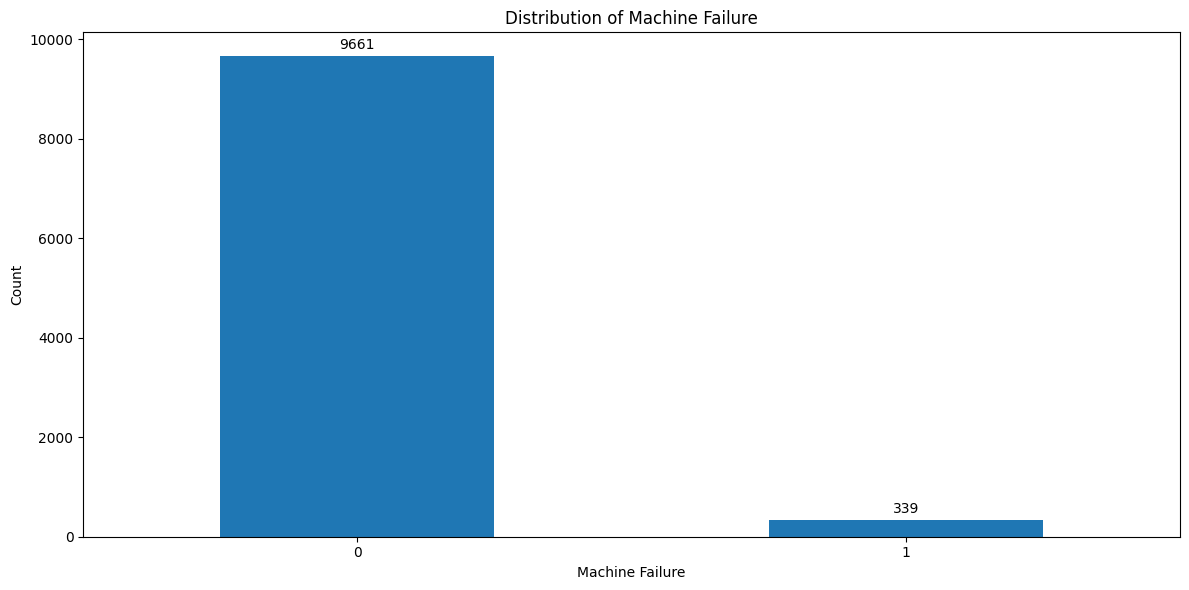

In [17]:
plt.figure(figsize=(12, 6))
counts = mill_df['Machine failure'].value_counts().sort_index()
ax = counts.plot(kind='bar')
plt.title('Distribution of Machine Failure')
plt.xticks(rotation=0)
plt.xlabel('Machine Failure')
plt.ylabel('Count')

# add data labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Type

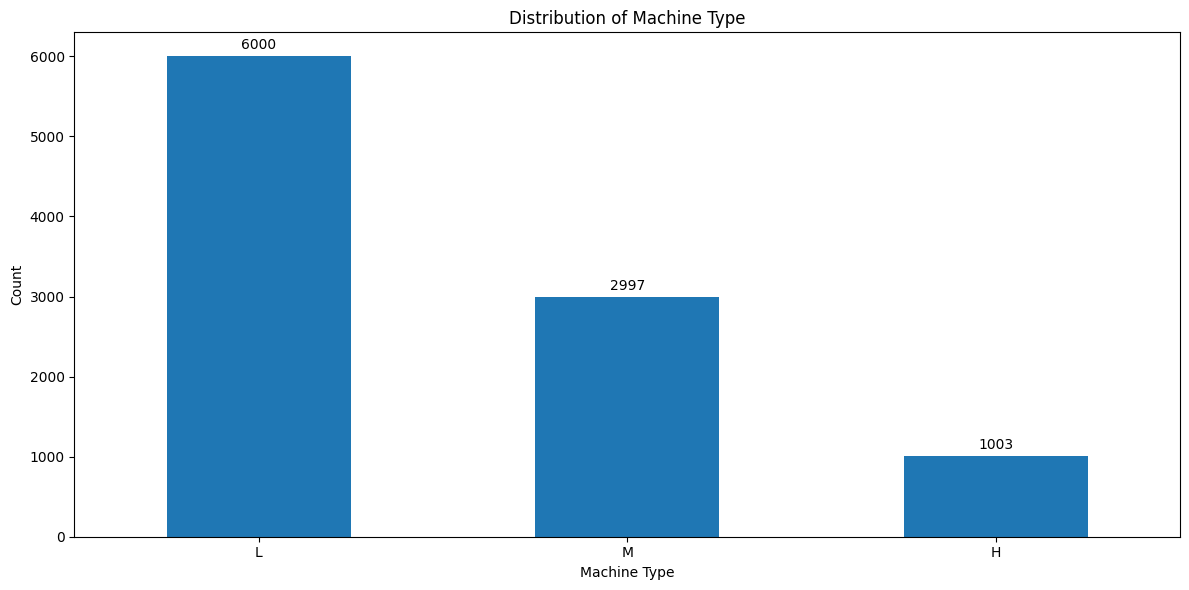

In [19]:
plt.figure(figsize=(12, 6))
# ensure consistent order L, M, H
counts = mill_df['Type'].value_counts().reindex(['L', 'M', 'H']).fillna(0).astype(int)
ax = counts.plot(kind='bar')
plt.title('Distribution of Machine Type')
plt.xticks(rotation=0)
plt.xlabel('Machine Type')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Air temperature [K]

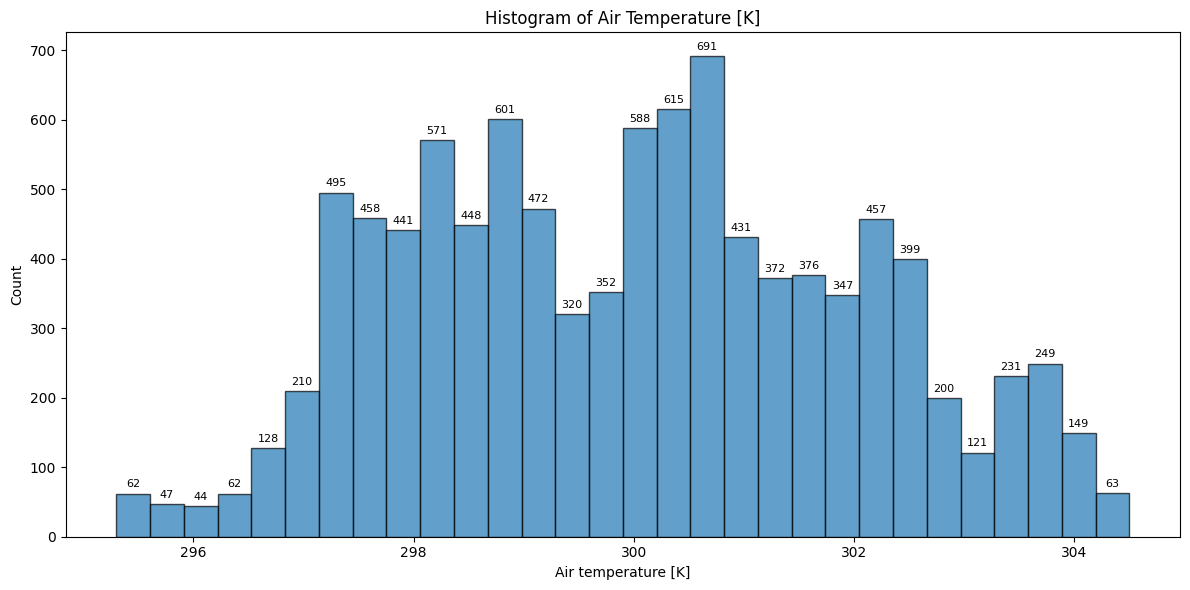

In [25]:
plt.figure(figsize=(12, 6))
data = mill_df['Air temperature [K]']
patches = plt.hist(data, bins=30, color='C0', edgecolor='black', alpha=0.7)[2]
plt.title('Histogram of Air Temperature [K]')
plt.xlabel('Air temperature [K]')
plt.ylabel('Count')

for p in patches:
    h = p.get_height()
    if h > 0:
        plt.annotate(f'{int(h)}', (p.get_x() + p.get_width() / 2., h),
                     ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()


#### Process temperature [K]

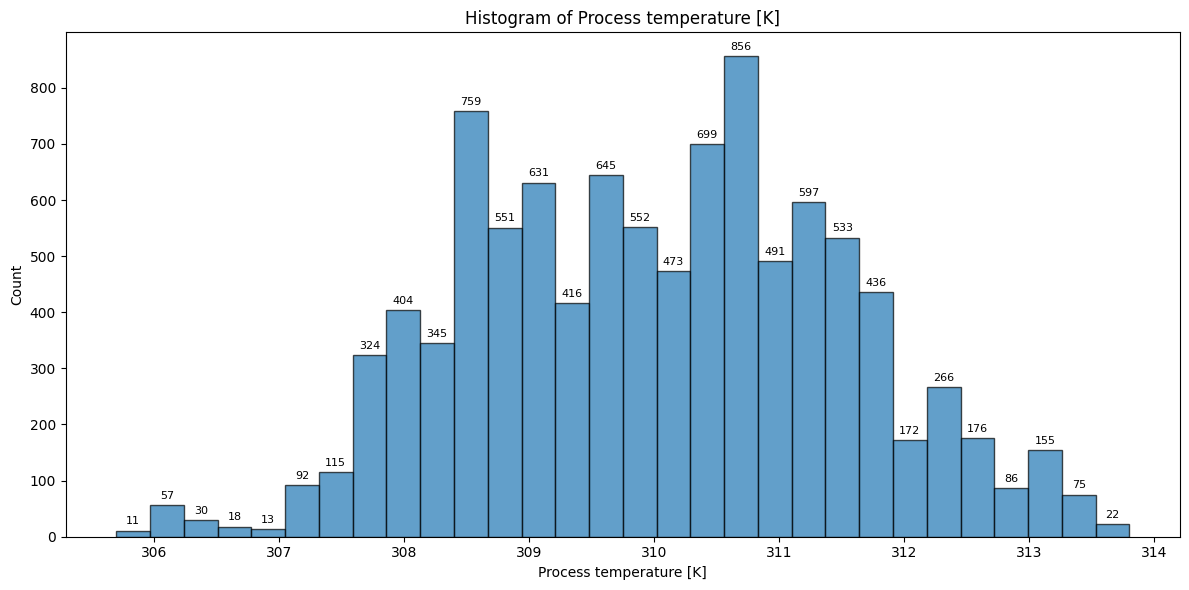

In [26]:
plt.figure(figsize=(12, 6))
data = mill_df['Process temperature [K]']
patches = plt.hist(data, bins=30, color='C0', edgecolor='black', alpha=0.7)[2]
plt.title('Histogram of Process temperature [K]')
plt.xlabel('Process temperature [K]')
plt.ylabel('Count')

for p in patches:
    h = p.get_height()
    if h > 0:
        plt.annotate(f'{int(h)}', (p.get_x() + p.get_width() / 2., h),
                     ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()


#### Rotational speed [rpm]

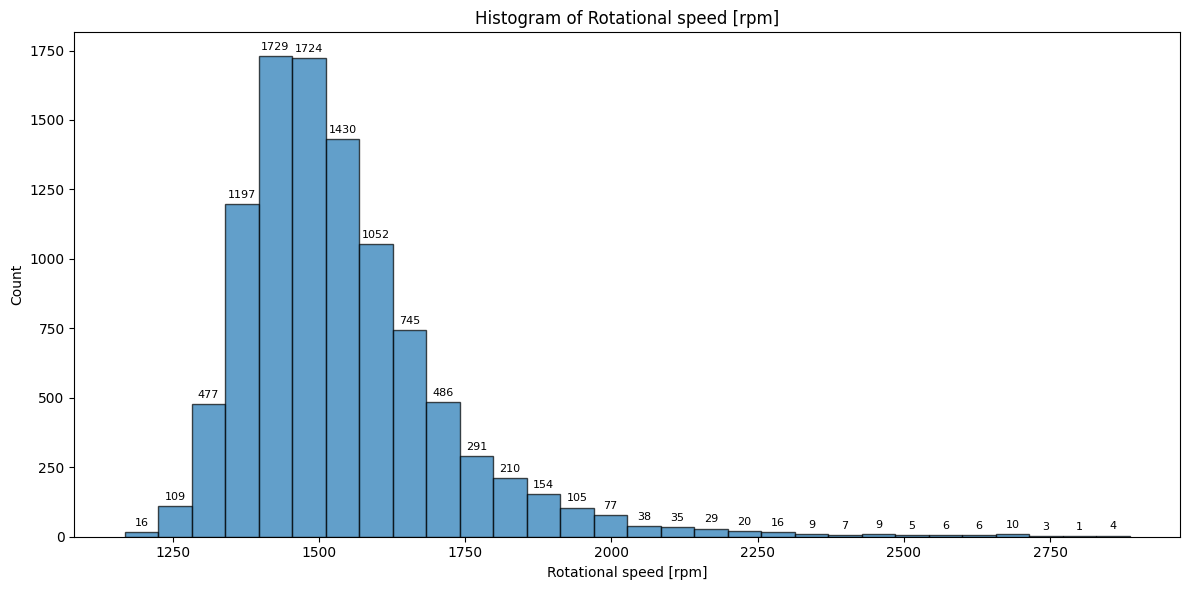

In [27]:
plt.figure(figsize=(12, 6))
data = mill_df['Rotational speed [rpm]']
patches = plt.hist(data, bins=30, color='C0', edgecolor='black', alpha=0.7)[2]
plt.title('Histogram of Rotational speed [rpm]')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Count')

for p in patches:
    h = p.get_height()
    if h > 0:
        plt.annotate(f'{int(h)}', (p.get_x() + p.get_width() / 2., h),
                     ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()
